In [1]:
# train slant model on press releases using media bi- and trigrams

## import
import os
import numpy as np
import pandas as pd
import pickle
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
import re
import joblib
from imblearn.over_sampling import SMOTE


## set wd
os.chdir("/home/nico/Projects/_rrpviol_med/")

In [2]:
## load press releases
pprs = pd.read_csv('_dt/releases/germanyPPRs.csv')
pprs.text = [str(t) for t in pprs.text]

In [3]:
## restrict to relevant time frame
pprs = pprs[pprs.year >= 2013]

In [4]:
## check if similar distribution of press releases across time for each party
pd.crosstab(pprs.year, pprs.party)

party,90gruene_fraktion,afd_bundesverband,afd_fraktion,fdp_bundesverband,fdp_fraktion,linke_fraktion,spd_fraktion,union_fraktion
year,,,,,,,,
2013,766,111,0,84,700,1113,1008,854
2014,942,283,0,580,0,1118,794,848
2015,787,155,0,598,0,1078,753,656
2016,799,354,0,598,0,925,721,626
2017,401,464,119,618,46,771,546,437
2018,584,242,1375,201,537,838,439,457
2019,638,161,772,106,246,391,222,249


In [5]:
## load vectorizer
vec = pickle.load(open('_dt/bitrigram_new_vectorizer.pkl', mode='rb'))

In [6]:
# drop numbers
numberEraser = lambda x : re.sub(r'\d+', '', x)
pprs['text_clean'] = pprs.text.apply(numberEraser)

In [7]:
## drop politician names
politician_names = pd.read_csv('_dt/releases/politician_names.csv', delimiter=';').name
additional_names = pd.Series(['Alternative für Deutschland', 'AfD', 'Jörg Meuthen', 'Björn Höcke', 'Bernd Lucke', 'Jürgen Trittin', 'Wolfgang Kubicki', 'wolfgang kubicki', 'Christian Lindner', 'christian lindner', 'FDP', 'Bundestagsfraktion', 'bundestagsfraktion', 'Fraktion', 'fraktion', 'CSU', 'SPD', 'Bundestag', 'Die Linke', 'Die Grünen', 'Bündnis 90'])


In [8]:
politician_names = politician_names.append(additional_names)

for name in politician_names:
    nameEraser = lambda x : re.sub(name, '', x)
    pprs['text_clean'] = pprs.text_clean.apply(nameEraser)

In [9]:
## preprocess and vectorize
DocTokenizer = RegexpTokenizer(r'\w+') 
Tokenizer = lambda x : DocTokenizer.tokenize(x)
pprs['tokens'] = [' '.join(t) for t in pprs.text_clean.apply(Tokenizer)]

In [10]:
## define outcome
pprs['label'] = 0
pprs.loc[[re.match('.*afd.*', p) != None for p in pprs.party], 'label'] = 1

In [11]:
pd.crosstab(pprs.label, pprs.year)

year,2013,2014,2015,2016,2017,2018,2019
label,,,,,,,
0,4525,4282,3872,3669,2819,3056,1852
1,111,283,155,354,583,1617,933


In [12]:
# define train-test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    vec.transform(pprs.tokens), pprs.label, test_size = 0.1, random_state = 42
)

In [13]:
# balance data
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [14]:
## fit model
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [15]:
## save model
joblib.dump(logreg, '_dt/bitrigram_classifier_fullset.pkl')

['_dt/bitrigram_classifier_fullset.pkl']

In [16]:
# assess overall performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, prediction)) # ok
print('Precision: ', precision_score(y_test, prediction)) # v bad
print('Recall: ', recall_score(y_test, prediction)) # meagre
print('F1: ', f1_score(y_test, prediction)) # bad

Accuracy:  0.7663584637268848
Precision:  0.3474114441416894
Recall:  0.5889145496535797
F1:  0.43701799485861187


In [17]:
pd.crosstab(prediction, y_test)
# question is: do we care?

label,0,1
row_0,,
0,1900,178
1,479,255


In [18]:
# check performance across time 
# are later PPRs classified more accurately due to higher share of outcome?

years = [[]]*7
acc = [[]]*7
prec = [[]]*7
rec = [[]]*7
f1 = [[]]*7


for year in range(2013, 2020):
    temp = pprs.loc[pprs.year == year]
    prediction = logreg.predict(vec.transform(temp.tokens))
    years[year-2013] = year
    acc[year-2013] = accuracy_score(temp.label, prediction) # meagre
    prec[year-2013] = precision_score(temp.label, prediction) # really bad
    rec[year-2013] = recall_score(temp.label, prediction) # bad
    f1[year-2013] = f1_score(temp.label, prediction) # v bad

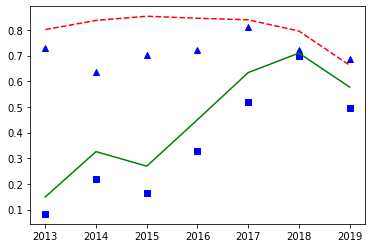

In [19]:
import matplotlib.pyplot as plt
plt.plot(years, acc, 'r--') # only bad in 2019
plt.plot(years, prec, 'bs') # really bad early on
plt.plot(years, rec, 'b^') # rel stable
plt.plot(years, f1, 'g-') # really bad early on


In [20]:
# Alternative 1: re-sample across time

# draw random sample for test set, stratify across time

if 'X_train' in locals():
    del X_train

for year in range(2013, 2020):
    temp = pprs.loc[(pprs.year == year) & (pprs.label == 0)] # take all press releases from that year
    temp_afd = pprs.loc[(pprs.year == year) & (pprs.label == 1)] # all afd press releases from that year
    temp = temp.loc[np.random.choice(temp.index, min(len(temp_afd.index)*3, len(temp.index)), replace=False)] # choose 3*the amount of afd data
    temp = temp.append(temp_afd) # append afd cases
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        temp.tokens, temp.label, test_size = 0.1, random_state = 42
    )
    if 'X_train' in locals():
        X_train = X_train.append(X_train_temp)
        X_test = X_test.append(X_test_temp)
        y_train = y_train.append(y_train_temp)
        y_test = y_test.append(y_test_temp)
        yearvec = yearvec.append(temp.year)
        labels_full = labels_full.append(temp.label)
    else:
        X_train = X_train_temp
        X_test  = X_test_temp
        y_train = y_train_temp
        y_test  = y_test_temp
        yearvec = temp.year
        labels_full = temp.label

X_train = vec.transform(X_train)
X_test  = vec.transform(X_test)

pd.crosstab(yearvec, labels_full)    

label,0,1
year,,
2013,333,111
2014,849,283
2015,465,155
2016,1062,354
2017,1749,583
2018,3056,1617
2019,1852,933


In [21]:
# balance data
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [22]:
## fit model
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [23]:
## save model
joblib.dump(logreg, '_dt/bitrigram_classifier_resampled.pkl')

['_dt/bitrigram_classifier_resampled.pkl']

In [24]:
# assess overall performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, prediction)) # good
print('Precision: ', precision_score(y_test, prediction)) # bad
print('Recall: ', recall_score(y_test, prediction)) # good
print('F1: ', f1_score(y_test, prediction)) # meagre

Accuracy:  0.7321428571428571
Precision:  0.5362318840579711
Recall:  0.74
F1:  0.6218487394957984


In [25]:
pd.crosstab(prediction, y_test)
# question is: do we care?

label,0,1
row_0,,
0,688,104
1,256,296


In [26]:
# check performance across time 
# are later PPRs classified more accurately due to higher share of outcome?

years = [[]]*7
acc = [[]]*7
prec = [[]]*7
rec = [[]]*7
f1 = [[]]*7


for year in range(2013, 2020):
    temp = pprs.loc[pprs.year == year]
    prediction = logreg.predict(vec.transform(temp.tokens))
    years[year-2013] = year
    acc[year-2013] = accuracy_score(temp.label, prediction) # meagre
    prec[year-2013] = precision_score(temp.label, prediction) # really bad
    rec[year-2013] = recall_score(temp.label, prediction) # bad
    f1[year-2013] = f1_score(temp.label, prediction) # v bad

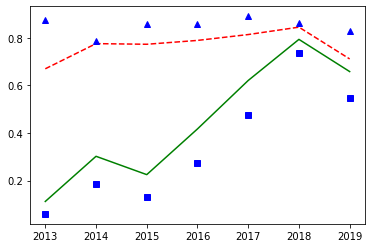

In [27]:
import matplotlib.pyplot as plt
plt.plot(years, acc, 'r--') # only bad in 2019
plt.plot(years, prec, 'bs') # really bad early on
plt.plot(years, rec, 'b^') # rel stable
plt.plot(years, f1, 'g-') # really bad early on

In [51]:
# Alternative 2: stratify across time

# draw random sample for test set, stratify across time

if 'X_train' in locals():
    del X_train

for year in range(2013, 2020):
    temp = pprs.loc[(pprs.year == year) & (pprs.label == 0)] # take all press releases from that year
    temp_afd = pprs.loc[(pprs.year == year) & (pprs.label == 1)] # all afd press releases from that year
    temp = temp.loc[np.random.choice(temp.index, 300, replace=False)] # choose 3*the amount of afd data
    temp_afd = temp_afd.loc[np.random.choice(temp_afd.index, 100, replace=False)] # choose 3*the amount of afd data
    temp = temp.append(temp_afd) # append afd cases
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        temp.tokens, temp.label, test_size = 0.1, random_state = 42
    )
    if 'X_train' in locals():
        X_train = X_train.append(X_train_temp)
        X_test = X_test.append(X_test_temp)
        y_train = y_train.append(y_train_temp)
        y_test = y_test.append(y_test_temp)
        yearvec = yearvec.append(temp.year)
        labels_full = labels_full.append(temp.label)
    else:
        X_train = X_train_temp
        X_test  = X_test_temp
        y_train = y_train_temp
        y_test  = y_test_temp
        yearvec = temp.year
        labels_full = temp.label

X_train = vec.transform(X_train)
X_test  = vec.transform(X_test)

pd.crosstab(yearvec, labels_full)    

label,0,1
year,,
2013,300,100
2014,300,100
2015,300,100
2016,300,100
2017,300,100
2018,300,100
2019,300,100


In [29]:
# balance data
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [30]:
## fit model
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [31]:
## save model
joblib.dump(logreg, '_dt/bitrigram_classifier_startified.pkl')

['_dt/bitrigram_classifier_startified.pkl']

In [32]:
# assess overall performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, prediction)) # good
print('Precision: ', precision_score(y_test, prediction)) # bad
print('Recall: ', recall_score(y_test, prediction)) # good
print('F1: ', f1_score(y_test, prediction)) # meagre

Accuracy:  0.7321428571428571
Precision:  0.4077669902912621
Recall:  0.75
F1:  0.5283018867924528


In [33]:
pd.crosstab(prediction, y_test)
# question is: do we care?

label,0,1
row_0,,
0,163,14
1,61,42


In [34]:
# check performance across time 
# are later PPRs classified more accurately due to higher share of outcome?

years = [[]]*7
acc = [[]]*7
prec = [[]]*7
rec = [[]]*7
f1 = [[]]*7


for year in range(2013, 2020):
    temp = pprs.loc[pprs.year == year]
    prediction = logreg.predict(vec.transform(temp.tokens))
    years[year-2013] = year
    acc[year-2013] = accuracy_score(temp.label, prediction) # meagre
    prec[year-2013] = precision_score(temp.label, prediction) # really bad
    rec[year-2013] = recall_score(temp.label, prediction) # bad
    f1[year-2013] = f1_score(temp.label, prediction) # v bad

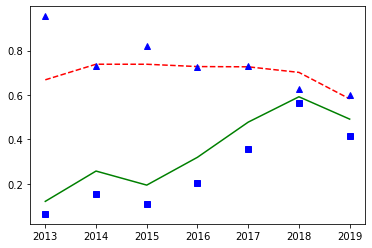

In [35]:
plt.plot(years, acc, 'r--') # only bad in 2019
plt.plot(years, prec, 'bs') # really bad early on
plt.plot(years, rec, 'b^') # rel stable
plt.plot(years, f1, 'g-') # really bad early on


In [36]:
# alternative 3: train only on fraktionen (post 2017)

# restrict sample to fraktionen and post 2017:
pprs_f = pprs.loc[[re.match('.*fraktion.*', p) != None for p in pprs.party]]
pprs_f = pprs_f[pprs_f.year > 2017]

In [37]:
pd.crosstab(pprs_f.label, pprs_f.year)

year,2018,2019
label,,
0,2855,1746
1,1375,772


In [38]:
# define train-test sample
X_train, X_test, y_train, y_test = train_test_split(
    vec.transform(pprs_f.tokens), pprs_f.label, test_size = 0.1, random_state = 42
)

In [39]:
# balance data
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [40]:
## fit model
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [41]:
## save model
joblib.dump(logreg, '_dt/bitrigram_classifier_1819_fraktionen.pkl')

['_dt/bitrigram_classifier_1819_fraktionen_strat.pkl']

In [42]:
# assess overall performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, prediction)) # ok
print('Precision: ', precision_score(y_test, prediction)) # meagre
print('Recall: ', recall_score(y_test, prediction)) # ok
print('F1: ', f1_score(y_test, prediction)) # hmmm

Accuracy:  0.7081481481481482
Precision:  0.5331125827814569
Recall:  0.7419354838709677
F1:  0.6204238921001927


In [43]:
pd.crosstab(prediction, y_test)
# question is: do we care?

label,0,1
row_0,,
0,317,56
1,141,161


In [44]:
# check performance across time 
# are later PPRs classified more accurately due to higher share of outcome?

years = [[]]*7
acc = [[]]*7
prec = [[]]*7
rec = [[]]*7
f1 = [[]]*7


for year in range(2013, 2020):
    temp = pprs.loc[pprs.year == year]
    prediction = logreg.predict(vec.transform(temp.tokens))
    years[year-2013] = year
    acc[year-2013] = accuracy_score(temp.label, prediction) # meagre
    prec[year-2013] = precision_score(temp.label, prediction) # really bad
    rec[year-2013] = recall_score(temp.label, prediction) # bad
    f1[year-2013] = f1_score(temp.label, prediction) # v bad

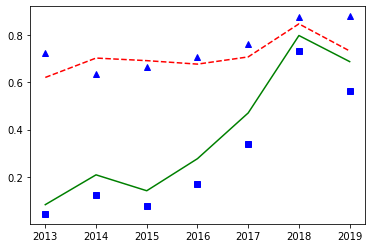

In [45]:
plt.plot(years, acc, 'r--') # rel stable
plt.plot(years, prec, 'bs') # really bad early on
plt.plot(years, rec, 'b^') # rel stable
plt.plot(years, f1, 'g-') # really bad early on


In [46]:
import eli5

In [47]:
eli5.show_weights(logreg, feature_names = vec.get_feature_names())

In [48]:
import matplotlib as plt
import seaborn as sns

def FeaturePlot(clf, vectorizer):

    feature_names = vectorizer.get_feature_names()
    
    top30_index = np.argsort(clf.coef_[0])[-30:]
        
    top30_coefs = pd.Series([clf.coef_[0][j] for j in top30_index])
    top30_features = pd.Series([feature_names[j] for j in top30_index])
    top30 = pd.concat([top30_coefs, top30_features], axis = 1)
    
    # plot
    sns.set(rc={'figure.figsize':(10,10)})
    plot = sns.barplot(data=top30, x=0, y=1, alpha=.8)
    plot.set(xlim=(0,None))

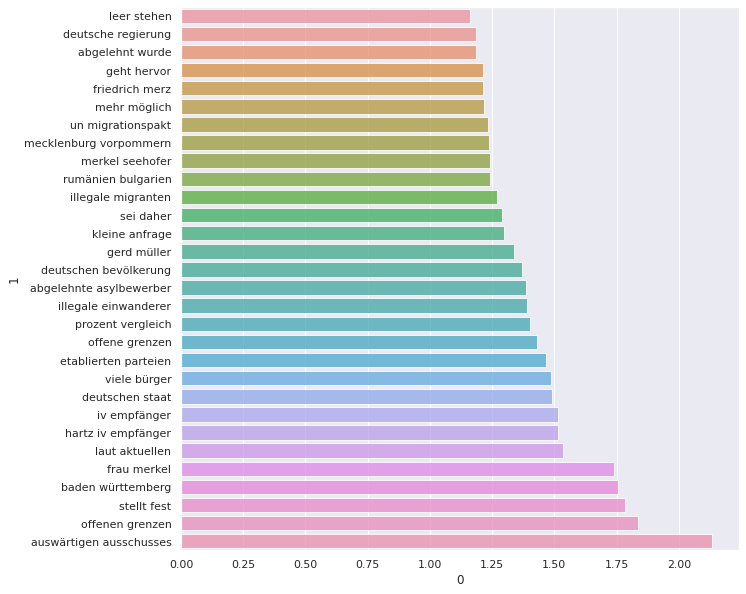

In [49]:
FeaturePlot(logreg, vec)